In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.optimize import curve_fit
from skimage.measure import block_reduce
import sys
sys.path.insert(0,'..')
from functions import getRad, lowPass, vint, mean_mask
from ppagg_io import load_ppagg
from dataloader import DataLoaderDALES, DataLoaderMicroHH

In [2]:
lps = [ '../../bomex200_from100_12hr/ppagg_merged',
        '../../bomex200_fiso_from100_12hr/ppagg_merged',
        '../../bomex100_e12/ppagg',
        '../../bomex100a5_from100_12hr/ppagg_merged',
        '../../bomex100_ldelta_from100_12hr/ppagg_merged',
      ]
labs = [r'D1: $\Delta x = 200m$',
        r'D3: $\Delta x = 200m$, fiso',
        r'D4: $\Delta x = 100m$',
        r'D5: $\Delta x = 100m$, a5',
        r'D6: $\Delta x = 100m$, nocorr',
        ]
mods = ['dales','dales','dales','dales','dales']
lines = ['-',
         (0, (3, 2, 1, 2, 1, 2)),
         '--',
         (0,(4,4)),
         (0,(1,3))
        ]

sp = '../../bomex_comparisons'

# Loading loop
ld = []
for i in range(len(lps)):
    
    lp = lps[i]
    mod = mods[i]

    if mod == 'dales':
        dl = DataLoaderDALES(lp+'/..')
    elif mod == 'microhh':
        dl = DataLoaderMicroHH(lp+'/..')
    
    ld.append(load_ppagg(dl, lp))

Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions


../ppagg_io.py:119: RuntimeWarning: divide by zero encountered in true_divide
  ld['Gamrat_av_time'] = ld['Gamma_qt_av_time']/ld['Gamma_thlv_av_time']


Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions


In [3]:
#%% Function for plotting chosen variable comparison

def plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,
                    sharex=True,alpha=0.75,lw=2):
    ndt = int((tpltmax-tpltmin)/dit)
    nvar = len(pltvars)

    fig,axs = plt.subplots(nrows=ndt,ncols=nvar,figsize=(3.2*nvar,3*ndt+0.25),
                           sharex=sharex,sharey=True,squeeze=False)
    col_av = 'k'
    col_moist = plt.cm.RdYlBu(0.99)
    col_dry = plt.cm.RdYlBu(0)
    lns= []; lbs = []
    for l in range(len(lps)):
    
        itpltmin = np.where(ld[l]['time'][ld[l]['plttime']]>=tpltmin)[0][0]
        itpltmax = np.where(ld[l]['time'][ld[l]['plttime']]<tpltmax)[0][-1]+1
        idtplt = int(round(dit/(ld[l]['time'][ld[l]['plttime'][1]]-ld[l]['time'][ld[l]['plttime'][0]])))
        plttime_var = np.arange(itpltmin,itpltmax,idtplt)
        
        pltvars_moist = []
        pltvars_dry = []
        pltvars_av = []
        for p in range(nvar):
            if '_av' in pltvars[p]:
                pltvars_av.append(ld[l][pltvars[p]+'_time'])
            else:
                pltvars_moist.append(ld[l][pltvars[p]+'_moist_time'])
                pltvars_dry.append(ld[l][pltvars[p]+'_dry_time'])
        
        for i in range(len(plttime_var)):
            
            ti = ld[l]['time'][plttime_var[i]]
            itmn_min = np.where(ld[l]['time'][ld[l]['plttime']] >= ti-tav)[0][0]
            itmn_max = np.where(ld[l]['time'][ld[l]['plttime']] <= ti+tav)[0][-1]
            
            for p in range(nvar):
                if '_av' in pltvars[p]:
                    
                    pltvar_av_mn = np.mean(ld[l][pltvars[p]+'_time'][itmn_min:itmn_max,:],axis=0)
                    
                    diffz = len(ld[l]['zflim']) - len(pltvar_av_mn)
                    if diffz != 0:
                        zplt = ld[l]['zflim'][diffz//2:-diffz//2]
                    else:
                        zplt = ld[l]['zflim']
                    
                    if l == 0:
                        lab = labs[l]+', slab-mean'
                    else:
                        lab = labs[l]

                    ln = axs[i,p].plot(pltvar_av_mn, zplt, 
                                  color=col_av, linestyle=lines[l],
                                  alpha=alpha, lw=lw)
                    if i == 0:
                        lns.append(ln[0])
                        lbs.append(lab)
                    # axs[i,p].set_xlim((-0.05,0.05))
                else:
                    pltvar_moist_mn = np.mean(ld[l][pltvars[p]+'_moist_time'][itmn_min:itmn_max,:],axis=0)
                    pltvar_dry_mn = np.mean(ld[l][pltvars[p]+'_dry_time'][itmn_min:itmn_max,:],axis=0)
                    
                    diffz = len(ld[l]['zflim']) - len(pltvar_moist_mn)
                    if diffz != 0:
                        zplt = ld[l]['zflim'][diffz//2:-diffz//2]
                    else:
                        zplt = ld[l]['zflim']
                    
                    # Ugly but works if you start with moist/dry var:
                    if l == 0:
                        labm = labs[l]+', moist'
                        labd = labs[l]+', dry'
                    else:
                        labm = labs[l]
                        labd = labs[l]

                    lnm = axs[i,p].plot(pltvar_moist_mn, zplt, 
                                  color=col_moist, linestyle=lines[l],
                                  alpha=alpha, lw=lw)
                    lnd = axs[i,p].plot(pltvar_dry_mn, zplt, 
                                  color=col_dry, linestyle=lines[l], 
                                  alpha=alpha, lw=lw)
                    if i == 0 and p == 0:
                        lns.append(lnm[0])
                        lns.append(lnd[0])
                        lbs.append(labm)
                        lbs.append(labd)
    
        for i in range(len(plttime_var)):
            axs[i,0].set_ylabel('Height [m]')
            for p in range(nvar):
                axs[i,p].set_title('%.0f'%(ld[l]['time'][plttime_var[i]]-tav)+'-'+
                                   '%.0f hr'%(ld[l]['time'][plttime_var[i]]+tav))
    
    for p in range(nvar):
        axs[-1,p].set_xlabel(varlab[p])
    # axs[-1,-1].legend(loc='best',bbox_to_anchor=(1,-0.25),ncol=2)
    fig.legend(lns, lbs, bbox_to_anchor=(0.9,0.075),ncol=len(lps))

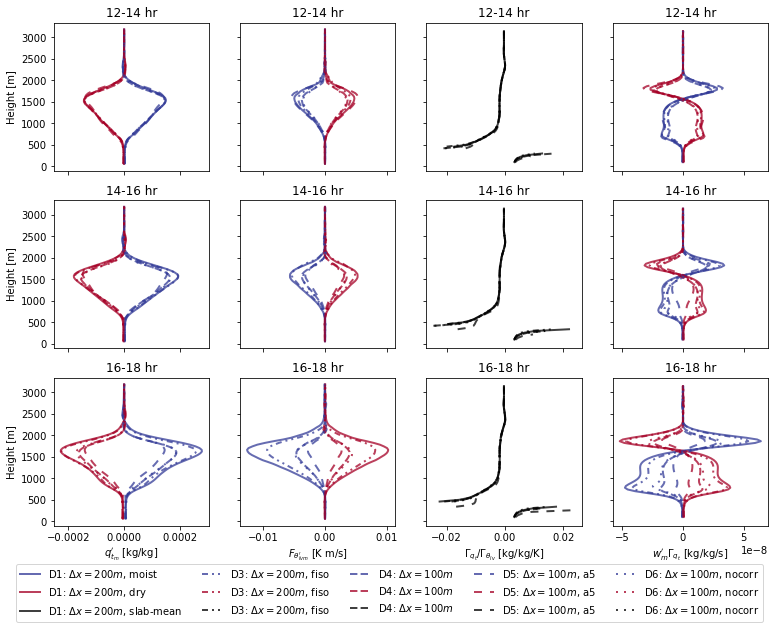

In [4]:
##% Compare various variables in feedback after restart

# Minus 'moist_time' or 'dry_time'
pltvars = ['qtpf','wthlvpf_anom', 'Gamrat_av','qtpf_prod_wex']
varlab = [r"${q_{t_m}'}$ [kg/kg]", 
          r"$F_{{\theta_{lv}'}_m}$ [K m/s]", 
          r"$\Gamma_{q_t}/\Gamma_{\theta_{lv}}$ [kg/kg/K]",
          r"$w_m'\Gamma_{q_t}$ [kg/kg/s]"]

tpltmin = 13
tpltmax = 19
dit = 2.0 # Rounds to closest multiple of dt in time
tav = 1.0 # Averaging time centred around current time


plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines,sharex='col')
plt.savefig(sp+'/comparison_vars.pdf',bbox_inches='tight')

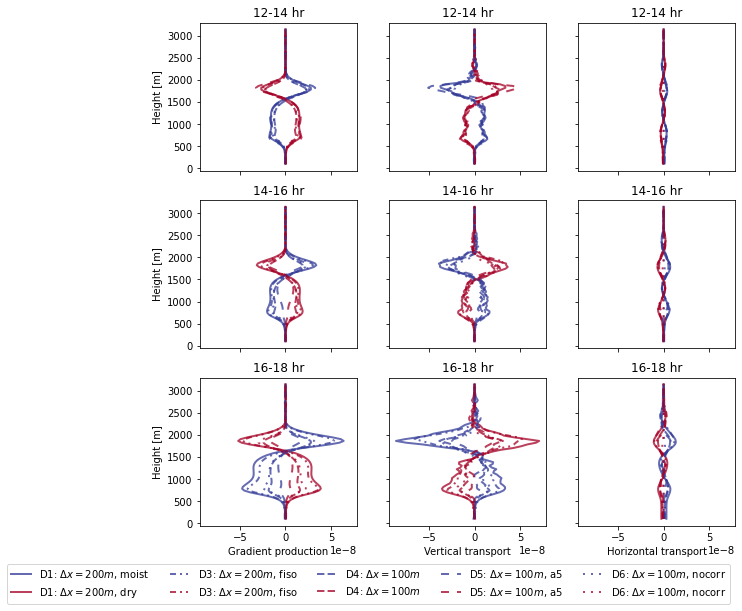

In [5]:
#%% qtpf important budget terms
pltvars = ['qtpf_prod_wex','qtpf_vdiv', 'qtpf_hdiv']
varlab = [r"Gradient production", 
          r"Vertical transport",
          r"Horizontal transport"]

tpltmin = 13
tpltmax = 19
dit = 2.0 # Rounds to closest multiple of dt in time
tav = 1.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines)
plt.savefig(sp+'/comparison_qtpf.pdf',bbox_inches='tight')

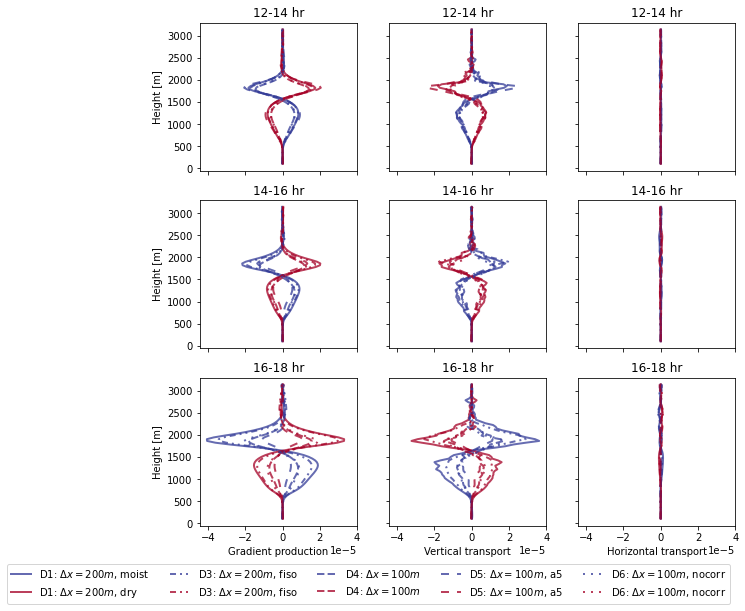

In [6]:
#%% thlvpf important budget terms

pltvars = ['thlvpf_prod','thlvpf_vdiv', 'thlvpf_hdiv']
varlab = [r"Gradient production", 
          r"Vertical transport",
          r"Horizontal transport"]

tpltmin = 13
tpltmax = 19
dit = 2.0 # Rounds to closest multiple of dt in time
tav = 1.0 # Averaging time centred around current time

plot_comparison(ld,pltvars,varlab,tpltmin,tpltmax,dit,tav,lines)
plt.savefig(sp+'/comparison_thlvpf.pdf',bbox_inches='tight')

In [7]:
# Vertically integrated figure

lps = ['../../bomex200_e12/ppagg_meansub',
       '../../bomex200a5',
       '../../bomex200_fiso_from100_12hr/ppagg_merged',
       '../../bomex100_e12/ppagg',
       '../../bomex100a5',
       '../../bomex100_ldelta_from100_12hr/ppagg_merged',
       '../../bomex50',
       '../../bomex_mhh/bomex_200m/ppagg',
       '../../bomex_mhh/bomex_100m/ppagg',
       '../../bomex_mhh/bomex_50m/ppagg',
       ]
sp = '../../bomex_comparisons'

labs = [
        r'D1: $\Delta x = 200m$',
        r'D2: $\Delta x = 200m$, a5',
        r'D3: $\Delta x = 200m$, fiso',
        r'D4: $\Delta x = 100m$',
        r'D5: $\Delta x = 100m$, a5',
        r'D6: $\Delta x = 100m$, nocorr',
        r'D7: $\Delta x = 50m$',
        r'M1: $\Delta x = 200m$',
        r'M2: $\Delta x = 100m$',
        r'M3: $\Delta x = 50m$',
        ]
mods = [
        'dales',
        'dales',
        'dales',
        'dales',
        'dales',
        'dales',
        'dales',
        'microhh',
        'microhh',
        'microhh',
        ]

src = ['ppagg',
       'cape',
       'ppagg',
       'ppagg',
       'cape',
       'ppagg',
       'cape',
       'ppagg',
       'ppagg',
       'ppagg',
       ]

ls = ['-',
      '-.',
      (0, (3, 2, 1, 2, 1, 2)),
      '--',
      (0,(4,4)),
      (0,(1,3)),
      ':',
      '-',
      '--',
       ':'
      ]

tmin = [6.,
        6.,
        6.,
        6.,
        6.,
        6.,
        20.,
        6.,
        6.,
        6.
        ]

tmax = [
        18.,
        36.,
        24.,
        36.,
        36.,
        36.,
        36.,
        12.,
        36.,
        36.
        ]

load_cape = False
klp = 4
alpha=0.9
lw=2

col_moist_mhh = plt.cm.RdYlBu(0.7)
col_dry_mhh = plt.cm.RdYlBu(0.3)
col_moist_dal = plt.cm.RdYlBu(0.99)
col_dry_dal = plt.cm.RdYlBu(0.01)

Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...
Set paths to all datasets and extracted dimensions
Initialising dataloader...


../ppagg_io.py:119: RuntimeWarning: divide by zero encountered in true_divide
  ld['Gamrat_av_time'] = ld['Gamma_qt_av_time']/ld['Gamma_thlv_av_time']


Set paths to all datasets and extracted dimensions
Initialising dataloader...


../ppagg_io.py:119: RuntimeWarning: divide by zero encountered in true_divide
  ld['Gamrat_av_time'] = ld['Gamma_qt_av_time']/ld['Gamma_thlv_av_time']


Set paths to all datasets and extracted dimensions


../ppagg_io.py:119: RuntimeWarning: divide by zero encountered in true_divide
  ld['Gamrat_av_time'] = ld['Gamma_qt_av_time']/ld['Gamma_thlv_av_time']


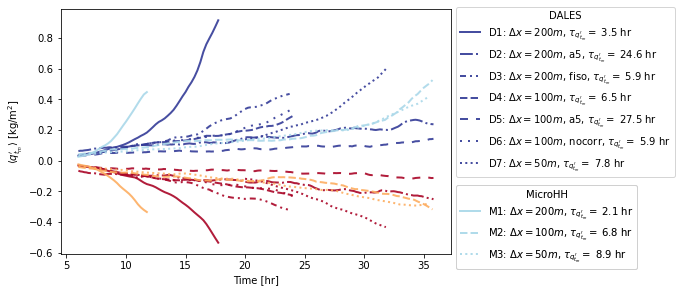

In [8]:
f1 = plt.figure(figsize=(7,4.5)); axs1 = plt.gca()
labs_leg = []
for i in range(len(lps)):
    lp = lps[i]
 
    if src[i] == 'cape':
        if load_cape:
            ds = nc.Dataset(lp+'/cape2d.001.nc')
            time  = np.ma.getdata(ds.variables['time'][:]) / 3600

            itpltmin = np.where(time>=tmin[i])[0][0]
            itpltmax = np.where(time<tmax[i])[0][-1]+1
            plttime_var = np.arange(itpltmin,itpltmax,1)

            sz = ds.dimensions['xt'].size
            circ_mask = np.zeros((sz,sz))
            rad = getRad(circ_mask)
            circ_mask[rad<=klp] = 1

            twppf_moist = np.zeros(len(plttime_var))
            twppf_dry = np.zeros(len(plttime_var))

            for j in range(len(plttime_var)):
                twpp = np.ma.getdata(ds.variables['twp'][plttime_var[j],:,:])
                twpp -= np.mean(twpp)
                twppf = lowPass(twpp, circ_mask)
                mask_moist = np.zeros(twppf.shape)
                mask_moist[twppf > 0] = 1
                mask_dry = 1 - mask_moist

                twppf_moist[j] = mean_mask(twppf, mask_moist)
                twppf_dry[j] = mean_mask(twppf, mask_dry)

            np.save(lp+'/time_twppf.npy', time)
            np.save(lp+'/twppf_moist.npy',twppf_moist)
            np.save(lp+'/twppf_dry.npy',twppf_dry)
            
        else:
            time = np.load(lp+'/time_twppf.npy')
            twppf_moist = np.load(lp+'/twppf_moist.npy')
            twppf_dry = np.load(lp+'/twppf_dry.npy')

            itpltmin = np.where(time>=tmin[i])[0][0]
            itpltmax = np.where(time<tmax[i])[0][-1]+1
            plttime_var = np.arange(itpltmin,itpltmax,1)

        [exp_moist,fac_moist], cov = curve_fit(lambda x, a, b: b * np.exp(x*a), 
                                               time[plttime_var]*3600, 
                                               twppf_moist,
                                               absolute_sigma=True,
                                               p0=[5e-5,0])
        tau = 1./exp_moist
        covtau = 1./np.sqrt(cov[0,0])

    elif src[i] == 'ppagg':
        if mods[i] == 'dales':
            dl = DataLoaderDALES(lp+'/..')
        elif mods[i] == 'microhh':
            dl = DataLoaderMicroHH(lp+'/..')
        ld = load_ppagg(dl, lp)
        time = ld['time']

        itpltmin = np.where(time>=tmin[i])[0][0]
        itpltmax = np.where(time<tmax[i])[0][-1]+1
        plttime_var = np.arange(itpltmin,itpltmax,1)

        zflim = ld['zflim']
        rhobfi = ld['rhobf'][0,ld['izmin']:ld['izmax']]
        qtpfmi = ld['qtpf_moist_time']
        qtpfdi = ld['qtpf_dry_time']

        wthlvpf_moist_anom = ld['wthlvpf_anom_moist_time']
        wthlvpf_dry_anom = ld['wthlvpf_anom_dry_time']
        Gamrat = ld['Gamrat_av_time']

        twppf_moist = vint(qtpfmi,rhobfi,zflim,plttime_var)
        twppf_dry = vint(qtpfdi,rhobfi,zflim,plttime_var)
        
        # Time scale estimate
        zmin = 500.
        izmin = np.argmin(np.abs(zflim-zmin))
        Gamratz = (Gamrat[:,1:] - Gamrat[:,:-1])/(zflim[1] - zflim[0])
        wthlvpf_anomi_moist = -vint(wthlvpf_moist_anom[:,izmin:-1]*Gamratz[:,izmin-2:],rhobfi[izmin:-1], zflim[izmin:-1], plttime=plttime_var)
        wthlvpf_anomi_dry   = -vint(wthlvpf_dry_anom  [:,izmin:-1]*Gamratz[:,izmin-2:],rhobfi[izmin:-1], zflim[izmin:-1], plttime=plttime_var)

        if i == 6: # For the 100 m MicroHH simulation, which need different fitting range due to failing routines
            itpltmax = np.where(time[plttime_var]<28.)[0][-1]+1
            coef,cov = np.polyfit(np.concatenate((twppf_dry[:itpltmax], twppf_moist[:itpltmax])),
                    np.concatenate((wthlvpf_anomi_dry[:itpltmax], wthlvpf_anomi_moist[:itpltmax])), 1,cov='unscaled')
        else:
            coef,cov = np.polyfit(np.concatenate((twppf_dry, twppf_moist)),
                                  np.concatenate((wthlvpf_anomi_dry, wthlvpf_anomi_moist)), 1,cov='unscaled')
        tau = 1./coef[0]
        covtau = 1./np.sqrt(cov[0,0])

    if mods[i] == 'dales':
        col_moist = col_moist_dal
        col_dry = col_dry_dal
    elif mods[i] == 'microhh':
        col_moist = col_moist_mhh
        col_dry = col_dry_mhh
    axs1.plot(time[plttime_var],twppf_moist,c=col_moist,linestyle=ls[i],lw=lw,alpha=alpha)
    axs1.plot(time[plttime_var],twppf_dry,c=col_dry,linestyle=ls[i],lw=lw,alpha=alpha)
    labs_leg.append(labs[i]+r", $\tau_{q_{t_m}'} =$ %.1f hr"%(tau/3600))
axs1.set_xlabel('Time [hr]')
axs1.set_ylabel(r"$\langle q_{t_m}'\rangle$ [kg/m$^2$]")
lines = axs1.get_lines()
dalind = [i for i in range(len(mods)) if mods[i] == 'dales']
mhhind = [i for i in range(len(mods)) if mods[i] == 'microhh']
leg1 = plt.legend([lines[2*i] for i in dalind],[labs_leg[i] for i in dalind],title='DALES',bbox_to_anchor=(1,1.03),loc='upper left')
leg2 = plt.legend([lines[2*i] for i in mhhind],[labs_leg[i] for i in mhhind],title='MicroHH',bbox_to_anchor=(1,0.3),loc='upper left')
axs1.add_artist(leg1)
axs1.add_artist(leg2)
plt.savefig(sp+'/twp_evo_num.pdf',bbox_inches='tight')